# やるべきだけどやってないこと
- モデルの次数と差分階差の情報量基準などを用いた選定
- 当てはめ残差の評価
- モデルの予測精度とナイーブ予測精度の比較
- 評価指標の検討（今回はとりあえずMSEで)

In [ ]:
#ドライブ設定
PATH_GMOUNT='/content/gdrive'
PATH_MYDRIVE=PATH_GMOUNT+'/My Drive'

#GDriveマウント
from google.colab import drive
drive.mount(PATH_GMOUNT)

Mounted at /content/gdrive


In [ ]:
!pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 44.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=a74814508aa0eb33da5fc3462460b55101c5b759d1a6ce92cb1a505aafaceacc
  Stored in directory: /root/.cache/pip/wheels/4f/ca/96/4cc5e192421cceb077fbf4ffec533382edd416fd3fa0af0bbd
Successfully built japanize_matplotlib


In [ ]:
# ライブラリのインポート

# from yahoo_finance_api2 import share
# from yahoo_finance_api2.exceptions import YahooFinanceError
import datetime as datetime
import pandas as pd
import numpy as np
import math

import sys
import os

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import japanize_matplotlib

import datetime

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

from IPython.display import display
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35486 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text

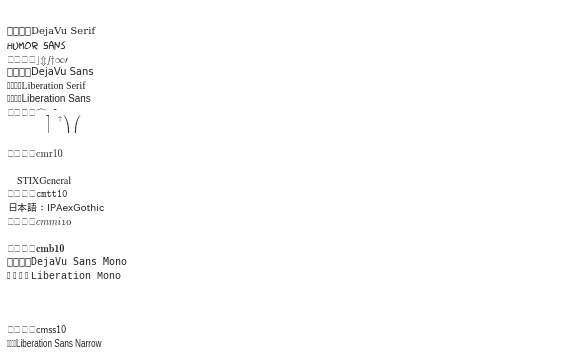

In [ ]:
# 日本語が表示できるフォントの確認

import matplotlib
# フォントを全て読み込み
fonts = set([f.name for f in matplotlib.font_manager.fontManager.ttflist])

# 描画領域のサイズ調整
plt.figure(figsize=(10,len(fonts)/4))

# フォントの表示
for i, font in enumerate(fonts):
    plt.text(0, i, f"日本語：{font}", fontname=font)

# 見やすいように軸を消す
plt.ylim(0, len(fonts))
plt.axis("off")

plt.show()

In [ ]:
# 日本語表示できるフォントに変更
plt.rcParams['font.family'] = "IPAexGothic"

In [ ]:
def add_datetime_columns(df, column):
  df["date"] = df[column].dt.date
  #df["year"] = pd.Categorical(df[column].dt.year)
  #df["mon"] = pd.Categorical(df[column].dt.month)
  #df["day"] = pd.Categorical(df[column].dt.day)
  #df["hr"] = pd.Categorical(df[column].dt.hour)
  #df["weekday"] = pd.Categorical(df[column].dt.weekday)
  #df["quarter"] = pd.Categorical(df[column].dt.quarter)
  #df["month"] = pd.Categorical(df[column].dt.strtime("%Y-%m"))

  return df

# データをロード

In [ ]:
df = pd.read_csv(f'{PATH_MYDRIVE}/株価データの分析/date/modeling_data.csv', encoding='shift_jis').drop("Unnamed: 0", axis = 1)
df

,open,high,low,close,volume,date,対数差収益率,差分,変化率,経過日数
0,59.825001,59.938000,58.631500,58.896000,33030000,2019-10-02,-0.023559,-1.403999,-0.023284,1
1,59.167000,59.549999,58.157001,59.471500,28368000,2019-10-03,0.009724,0.575500,0.009771,2
2,59.714500,60.623001,59.548500,60.548000,24282000,2019-10-04,0.017939,1.076500,0.018101,3
3,60.349998,60.945499,60.217999,60.412498,17040000,2019-10-07,-0.002240,-0.135502,-0.002238,4
4,59.938499,60.343498,59.473999,59.506500,20086000,2019-10-08,-0.015110,-0.905998,-0.014997,5
...,...,...,...,...,...,...,...,...,...,...
800,99.400002,101.379997,99.000000,99.480003,24405100,2022-12-05,-0.009604,-0.959999,-0.009558,801
801,99.300003,99.779999,96.419998,96.980003,24910700,2022-12-06,-0.025452,-2.500000,-0.025131,802
802,96.410004,96.879997,94.720001,94.940002,31045400,2022-12-07,-0.021260,-2.040001,-0.021035,803
803,95.379997,95.580002,93.449997,93.709999,32213300,2022-12-08,-0.013040,-1.230003,-0.012956,804


# モデリング
- 予測期間は任意の時点までを学習データに追加し、逐次的に次点だけを予測する
- 学習期間：2019-10-01~2022-08-31
- 予測期間：2022-09-01~2022-12-09
- AR, MA
- ARMA, ARIMA
- VARモデル

In [ ]:
df[(df["date"] <= "2022-08-31")].shape

(735, 10)

## ARモデル

### まずは差分系列

In [ ]:
# 予測が走るか確認
start = 735
pred_seq = np.arange(start, len(df))
preds = np.empty_like(pred_seq, dtype=float)

point = pred_seq[0]
i = 0

preds[i] = AutoReg(df.loc[(point-start+1):point, '対数差収益率'].values, lags=1, old_names=False).fit().forecast(steps=1)
# preds

In [ ]:
# # 予測
# start = 735 # 予測しだす開始点を指定
# pred_seq = np.arange(start, len(df_1)) # 予測したい時点の番号をarrayで生成
# preds = np.empty_like(pred_seq, dtype=float) # 予測値を入れれ空arrayを生成
#  # 繰り返し処理で予測したい時点全て計算
# for i, j in enumerate(pred_seq):
#     preds[i] = AutoReg(df_1.loc[(j-start+1):j, '対数差収益率'].values, lags=10, old_names=False).fit().forecast(steps=1)


In [ ]:
# 予測
start = 735 # 予測しだす開始点を指定
pred_seq = np.arange(start, len(df)) # 予測したい時点の番号をarrayで生成

preds_logdiff = np.empty_like(pred_seq, dtype=float) # 予測値を入れれ空arrayを生成
preds_diff = np.empty_like(pred_seq, dtype=float) # 予測値を入れれ空arrayを生成
preds_rate = np.empty_like(pred_seq, dtype=float) # 予測値を入れれ空arrayを生成

diffs_li = ["対数差収益率", "差分", "変化率"]
lag = 50 # ラグ（＝次数）の指定

 # 繰り返し処理で予測したい時点全て計算
for i, j in enumerate(pred_seq):
    preds_logdiff[i] = AutoReg(df.loc[(j-start+1):j, diffs_li[0]].values, lags=lag, old_names=False).fit().forecast(steps=1)

for i, j in enumerate(pred_seq):
    preds_diff[i] = AutoReg(df.loc[(j-start+1):j, diffs_li[1]].values, lags=lag, old_names=False).fit().forecast(steps=1)

for i, j in enumerate(pred_seq):
    preds_rate[i] = AutoReg(df.loc[(j-start+1):j, diffs_li[2]].values, lags=lag, old_names=False).fit().forecast(steps=1)

preds_li = [preds_logdiff, preds_diff, preds_rate]

疑問：定数cとホワイトノイズεはどう学習しているのか？

In [ ]:
# # 可視化
# ans = df_1.loc[start+1:, '対数差収益率']
# print('対数差収益率のグラフ')
# plt.plot(np.arange(len(ans)), ans, label='Actual')
# plt.plot(np.arange(len(preds)), preds, c='red', alpha=0.7, label='Predict')
# plt.legend()
# plt.show()

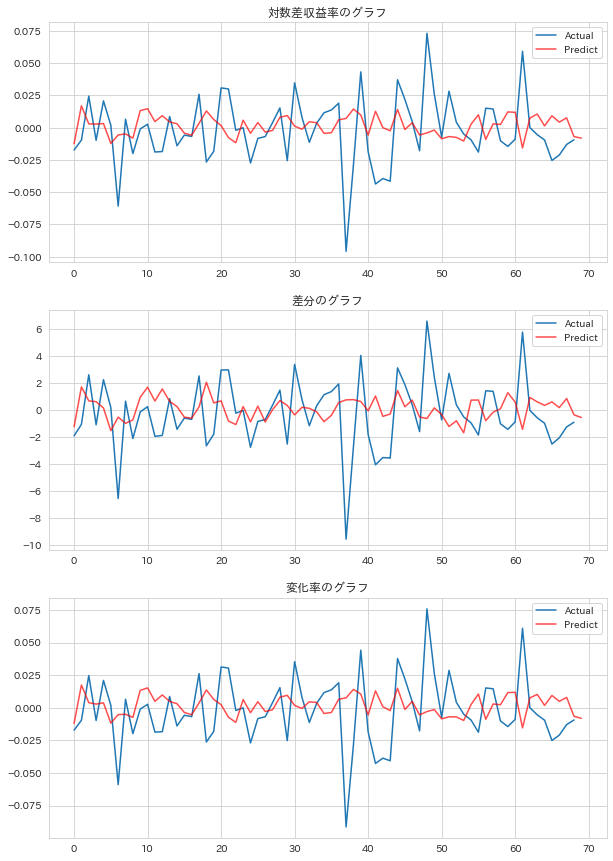

In [ ]:
# 可視化
fig = plt.figure(figsize=(10, 15))

for i in range(len(diffs_li)):
  ax = fig.add_subplot(len(diffs_li), 1, i+1)
  ans = df.loc[start+1:, diffs_li[i]]
  ax.set_title('{}のグラフ'.format(diffs_li[i]), loc='center')
  plt.plot(np.arange(len(ans)), ans, label='Actual')
  plt.plot(np.arange(len(preds_li[i])), preds_li[i], c='red', alpha=0.7, label='Predict')
  plt.legend()

plt.show()

In [ ]:
# # 原系列のプロット
# fig = plt.figure(figsize=(5, 4))
# ax = fig.add_subplot(1, 1, 1)

# ax.plot(df_1['close'], label='Actual')

# # 逆変換
# preds_exp = np.exp(preds)
# preds_close = [0]*(805-start)
# preds_close[0] = preds_exp[0]*df_1.loc[start, 'close']
# for i in range(1, len(preds)):
#     preds_close[i] = preds_exp[i]*df_1.loc[start+i, 'close']

# ax.plot([start+1+i for i in range(805-start)], preds_close, label='Estimate')

# ax.set_xlim(720, 810)
# ax.set_ylim(80, 130)

# plt.legend()

対数差収益率のmse:2.852
差分のmse:2.738
変化率のmse:2.854


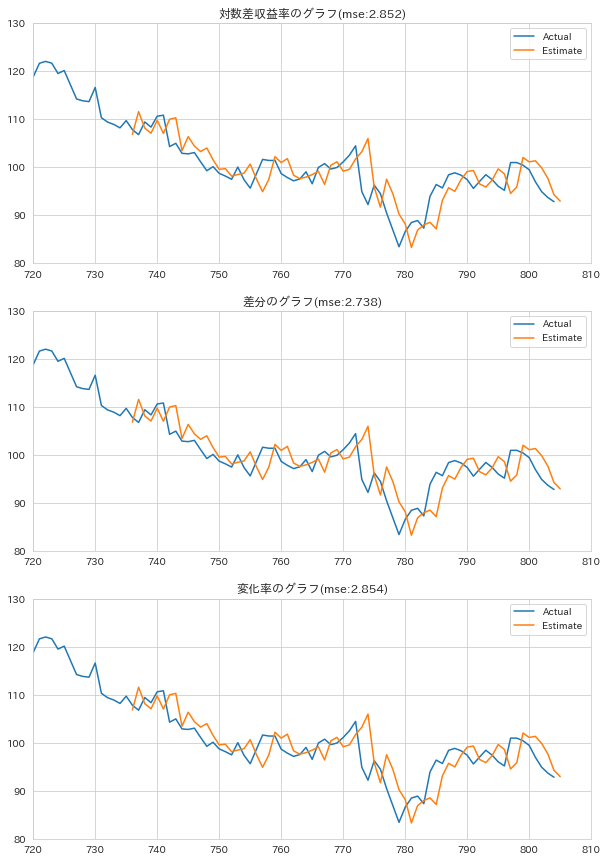

In [ ]:
# 原系列でのプロット

# 各定常化列の予測値を原系列としての予測値に逆変換
## 対数差収益率から
preds_log = preds_logdiff + np.log(df["close"])[start-1: -1] # 予測値の対数を計算
preds_close_from_logdiff = np.exp(preds_log) # 対数値を逆変換で原系列としての予測値にする
## 差分から
preds_close_from_diff = preds_diff + df["close"][start-1:-1]
## 変化率から
preds_close_from_rate = (preds_rate * df["close"][start-1:-1]) + df["close"][start-1:-1]
## リストに収納
preds_close_li = [preds_close_from_logdiff, preds_close_from_diff, preds_close_from_rate]


#　性能評価と可視化
fig = plt.figure(figsize=(10, 15))
diffs_li = ["対数差収益率", "差分", "変化率"]

for i in range(len(diffs_li)):
  # MSEの計算
  mse = np.square(np.array(df['close'][start:])-np.array(preds_close_li[i])).mean()**0.5
  print("{}のmse:{:.3f}".format(diffs_li[i], mse))

  # 可視化
  ax = fig.add_subplot(len(diffs_li), 1, i+1)

  ax.plot(df['close'], label='Actual')
  ax.plot([start+1+i for i in range(805-start)], preds_close_from_logdiff, label='Estimate')

  ax.set_title('{}のグラフ(mse:{:.3f})'.format(diffs_li[i], mse), loc='center')
  ax.set_xlim(720, 810)
  ax.set_ylim(80, 130)

  plt.legend()

plt.show()

lag = 10  
対数差収益率のmse:2.900  
差分のmse:2.719  
変化率のmse:2.904

lag = 20  
対数差収益率のmse:2.865  
差分のmse:2.679  
変化率のmse:2.867  

lag = 30  
対数差収益率のmse:2.863  
差分のmse:2.673  
変化率のmse:2.865  

lag = 50  
対数差収益率のmse:2.852  
差分のmse:2.738  
変化率のmse:2.854

lag = 80  
対数差収益率のmse:2.763  
差分のmse:2.847  
変化率のmse:2.771  

- 定常化の手法で、差分のみ次数をあげすぎると下がる  
なんでだろ。変化率を差分の方が変化量小さいから、定数cまたはホワイトノイズとの大小関係に由来があるのかも。